# Fit with the Fourier Transform of a Stretched Exponential

To run this example please first download and unzip the [zipped data files](https://www.dropbox.com/s/0xzasj7yvruyfem/basisdata.zip?dl=0).

This notebook showcases the use of Mantid's
[StretchedExpFT](http://docs.mantidproject.org/nightly/fitfunctions/StretchedExpFT.html) model to simultaneously fit a set of spectra with different momentum transfer values. An additional background file, representing the empty can run, is included in the fit

### Gathering all requirements
Substitute below `/tmp/basisdata` with the directory path that resulted after you unzipped the data files.

In [1]:
data_dir = '/tmp/basisdata/stretchedexpft_background'

In [2]:
# This code block finds where is the location of Mantid's python interface. No need to modify
from __future__ import print_function
import subprocess
import os
import sys
process = subprocess.Popen(['which', 'MantidPlot'], stdout=subprocess.PIPE)
out, err = process.communicate()
mantidbin = os.path.dirname(out)
sys.path.append(mantidbin)

In [11]:
# This code block loads the neccessary environment to run the fit. No need to modify
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.ion()
import numpy as np
import mantid
from mantid import plots
from mantid.simpleapi import (LoadDaveGrp, Resolution, DeltaFunction, Convolution, MultiDomainFunction,
                              Resolution, StretchedExpFT, GetQsInQENSData, LinearBackground,
                              TabulatedFunction, Fit, FunctionWrapper)
mantid.config.appendDataSearchDir(data_dir)

### Data Loading
Here we pass the two nexus files containing the data and the resolution. These are Dave files, so we use algorithm [LoadDaveGrp]()

In [8]:
data = LoadDaveGrp('data.grp', IsMicroEV=True)
resolution = LoadDaveGrp('resolution.grp', IsMicroEV=True)
background = LoadDaveGrp('background.grp', IsMicroEV=True)
q_values = GetQsInQENSData(data)  # list of momentum transfer values for each spectrum of data
print('Q values are',
      ', '.join(['{:3.2f}'.format(q) for q in q_values]))  # some quick checking
print('There are ', data.getNumberHistograms(), 'spectra in data')
print('There are ', resolution.getNumberHistograms(), 'spectra in resolution')
print('There are ', background.getNumberHistograms(), 'spectra in background')

Q values are 0.30, 0.50, 0.70, 0.90, 1.10, 1.30, 1.50, 1.70, 1.90
There are  9 spectra in data
There are  9 spectra in resolution
There are  9 spectra in background


### Plot data and resolution
Let's visualize the inputs with [matplotlib](https://matplotlib.org/)

<IPython.core.display.Javascript object>


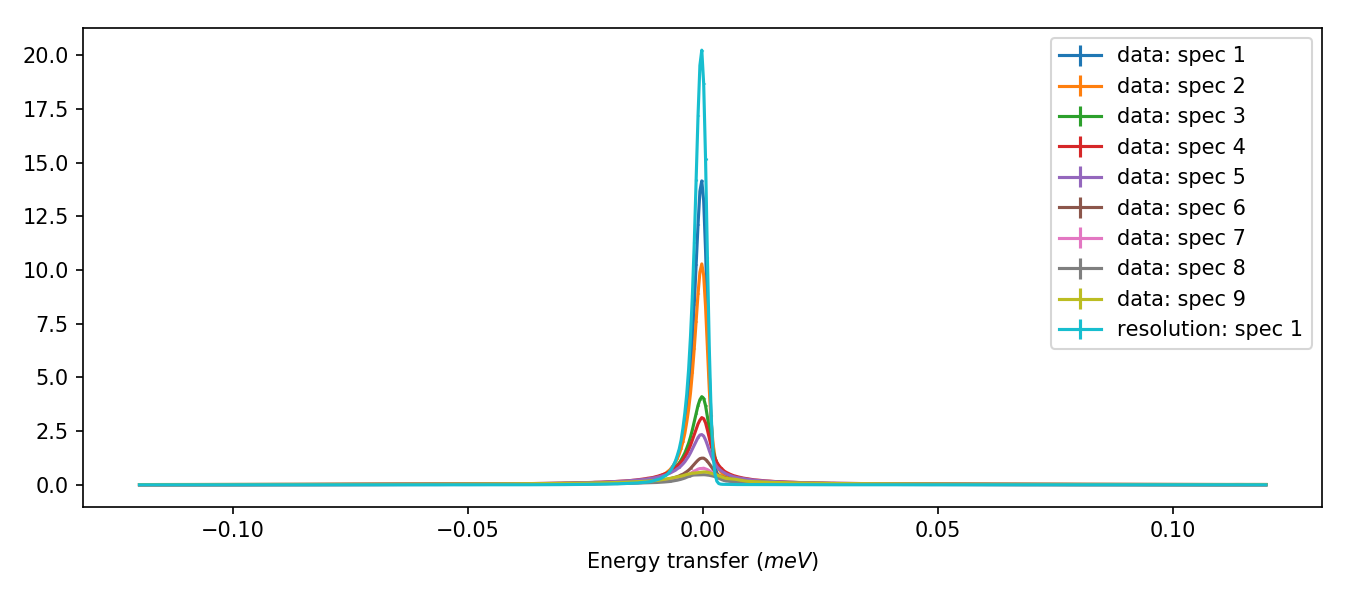

In [9]:
fig, ax = plt.subplots(subplot_kw={'projection':'mantid'})
fig.set_size_inches(9, 4)
n_spectra = data.getNumberHistograms()
list(ax.errorbar(data, wkspIndex=i) for i in range(n_spectra))  # plot all data spectra
ax.errorbar(resolution, wkspIndex=0)  # plot first histogram of the resolution
ax.legend()
plt.tight_layout()

### Instantiate the Fit Model
The $i^{th}$ spectrum with momentum transfer $Q_i$ is fitted with a convolution of the resolution and the model:

\begin{equation*}
R(E) \otimes \big( A_i \cdot \delta(E-C_i) + B_i \cdot StretchedExpFT(Q_i, E-C_i, \tau, \beta) \big) + (a_i + b_i E) + \lambda \cdot background\\
\end{equation*}

We have two global parameters, $\beta$ and $\lambda$. The rest of parameters are different for each spectrum.

We use the following operations and fit functions in creating the model:
- [Convolution](http://docs.mantidproject.org/nightly/fitfunctions/Convolution.html)
- [Resolution]()
- [DeltaFunction](http://docs.mantidproject.org/nightly/fitfunctions/DeltaFunction.html)
- [StretchedExpFT](http://docs.mantidproject.org/nightly/fitfunctions/StretchedExpFT.html)
- [LinearBackground](http://docs.mantidproject.org/nightly/fitfunctions/LinearBackground.html)
- [TabulatedFunction](http://docs.mantidproject.org/nightly/fitfunctions/TabulatedFunction.html)

In [16]:
# Create a model for each component spectrum
components = list()
for i in range(n_spectra):
    strexptf = FunctionWrapper('StretchedExpFT')
    single_model = DeltaFunction() + strexptf  # f0==DeltaFunction, f1==strexptf
    single_model.tie({"f1.Centre": "f0.Centre"})  # same Center of energies for DeltaDirac and teixeira
    resolution_function = Resolution(Workspace='resolution', WorkspaceIndex=i)
    convolved = Convolution(resolution_function, single_model)
    background_function = TabulatedFunction(Workspace='resolution', WorkspaceIndex=i)
    background_function.fix('XScaling')
    components.append(convolved + LinearBackground() + background_function)
# Gather all components into one global model and define which parameters are same for all components
# Function hiearchy for each component:
#  component_i
#  |_f0-Composite
#  |    |_f0-Convolution
#  |    |    |_f0-Resolution
#  |    |    |_f1-single_model
#  |    |         |_f0-DeltaFunction
#  |    |         |_f1-StretchedExpFT has parameter f0.f0.f1.f1.Beta
#  |    |_f1-LinearBackground
#  |_f1-TabulatedFunction has parameter f1.Scaling
print(components[0])

((composite=Convolution,FixResolution=true,NumDeriv=true;name=Resolution,Workspace=resolution,WorkspaceIndex=0,X=(),Y=();(name=DeltaFunction,Height=1,Centre=0;name=StretchedExpFT,Height=0.1,Tau=100,Beta=1,Centre=0;ties=(f1.Centre=f0.Centre)));name=LinearBackground,A0=0,A1=0);name=TabulatedFunction,Workspace=resolution,WorkspaceIndex=0,X=(),Y=(),Scaling=1,Shift=0,XScaling=1,ties=(XScaling=1)


In [17]:

# Gather all components, and set the global parameters
model = MultiDomainFunction(*components, Global=(['f0.f0.f1.f1.Beta','f1.Scaling']))

### Associate spectra to components
Each of the components in list `components` must fit one of the spectra of workspace `data`. In addition, we have to specify the energy domains for the fits. We will use the same domain for all spectra

In [18]:
e_start = -0.1  # meV
e_end = 0.1
domains = dict(InputWorkspace='data', WorkspaceIndex=0, StartX=e_start, EndX=e_end)  # init with first spectrum
# Continue with remaining spectra
for i in range(1, n_spectra):
    istr = str(i)  # cast integer to string
    domain = {'InputWorkspace_'+istr: 'data', 'WorkspaceIndex_'+istr: i,
              'StartX_'+istr: e_start, 'EndX_'+istr: e_end}
    domains.update(domain)

### Carry out the fit
We call algorithm [Fit](http://docs.mantidproject.org/nightly/algorithms/Fit-v1.html)

In [19]:
results = Fit(model, Output='fit', CreateOutput=True, MaxIterations=500, **domains)
print(results._fields)
print('Output status is ', results.OutputStatus,
      '; Chi-square is {:3.2f}'.format(results.OutputChi2overDoF))

('OutputStatus', 'OutputChi2overDoF', 'OutputNormalisedCovarianceMatrix', 'OutputParameters', 'OutputWorkspace', 'Function', 'CostFunction')
Output status is  success ; Chi-square is 1649.50


[namedtuple](https://docs.python.org/2/library/collections.html#collections.namedtuple) `results` contains the different results of the fit:
- OutputStatus: either `success` or `failure`
- OutputChi2overDoF: $\chi^2$ value of the fit
- OutputNormalisedCovarianceMatrix: [TableWorkspace](http://docs.mantidproject.org/nightly/api/python/mantid/api/ITableWorkspace.html?highlight=tableworkspace#mantid.api.ITableWorkspace) containing correlations between the different fit parameters
- OutputParameters: [TableWorkspace](http://docs.mantidproject.org/nightly/api/python/mantid/api/ITableWorkspace.html?highlight=tableworkspace#mantid.api.ITableWorkspace) containing optimized values for the fit parameters and estimation of their errors.
- OutputWorkspace: [WorkspaceGroup](http://docs.mantidproject.org/nightly/api/python/mantid/api/WorkspaceGroup.html) containing a [MatrixWorkspace](http://docs.mantidproject.org/nightly/api/python/mantid/api/MatrixWorkspace.html) for each spectra. In turn, each [MatrixWorkspace](http://docs.mantidproject.org/nightly/api/python/mantid/api/MatrixWorkspace.html) contains the experimental the data, the fit, and the residuals
- Function: the `model` instace with optimized fit parameter values. Can be used in [Fit]() for a successive second fitting if we change some of the fitting properties such as the energy domain range or the minimizer.
- CostFunction: string denoting the [cost function](http://doxygen.mantidproject.org/nightly/de/d10/classMantid_1_1API_1_1ICostFunction.html_) used. Default is 'Least Squares'

### Visualize a fit
Let's use matplotlib again to plot the first spectrum

<IPython.core.display.Javascript object>


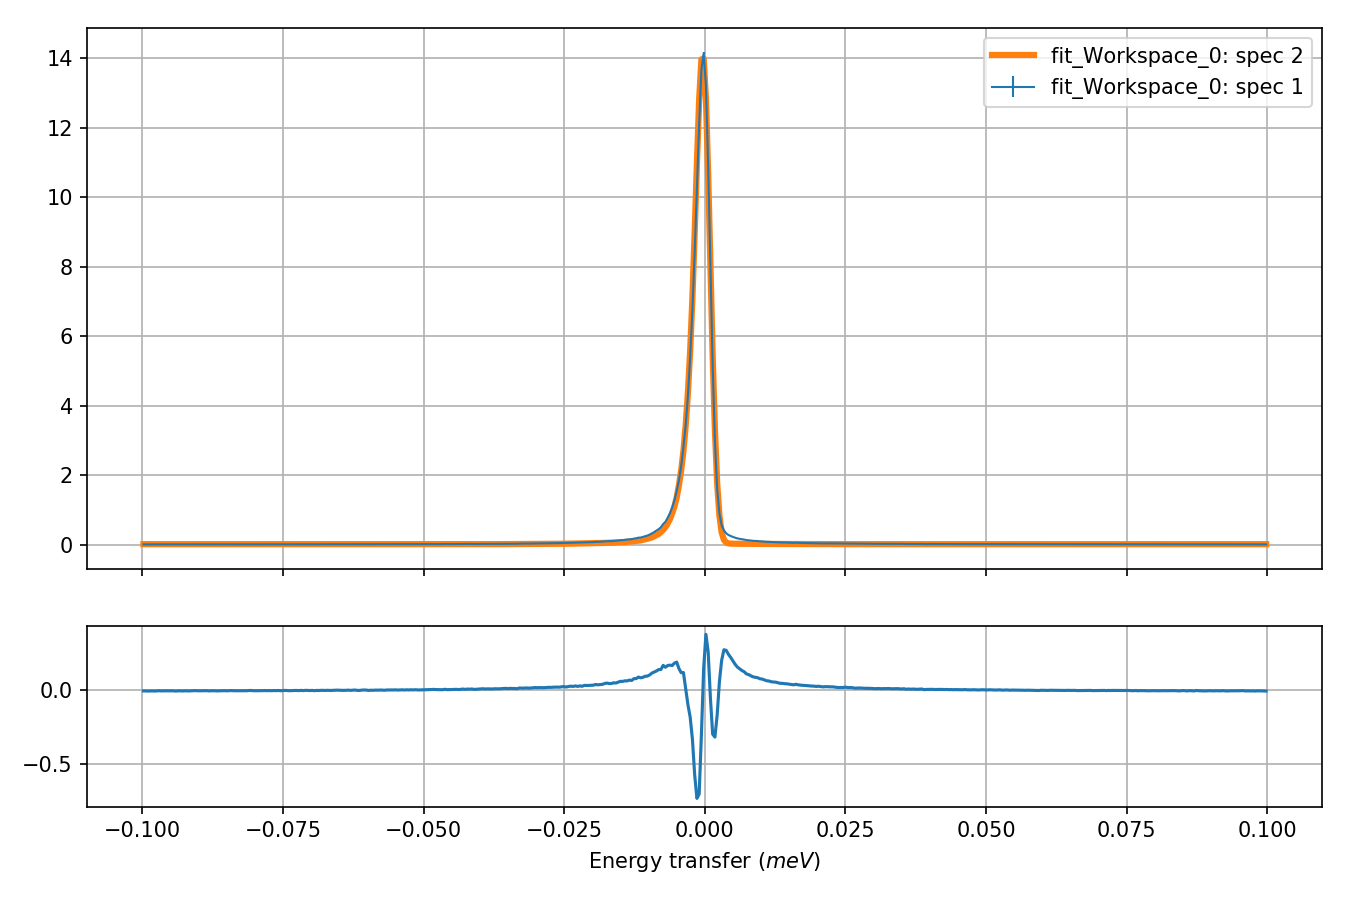

In [20]:
comparison = results.OutputWorkspace[0]  # MatrixWorkspace of first spectrum

# Create two panels, one double the height than the other
fig = plt.figure(figsize=(9, 6)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
ax_top = plt.subplot(gs[0], projection='mantid')
plt.setp(ax_top.get_xticklabels(), visible=False)
ax_bottom = plt.subplot(gs[1], projection='mantid', sharex=ax_top)
# Plot experimental data and model together in one panel
ax_top.errorbar(comparison, linewidth=1, wkspIndex=0)  # experimental data
ax_top.plot(comparison, linewidth=3, wkspIndex=1)  # model fit
ax_top.grid()
ax_top.legend()
ax_top.set_xlabel(' ')
# Plot residuals in the other panel
ax_bottom.plot(comparison, wkspIndex=2)  # residuals
ax_bottom.locator_params(axis='y', nbins=4)
ax_bottom.grid()
plt.tight_layout()

### Plot Q-dependence of EISF
Recalling the function hierarchy for all components:
```
model
  |_f0-component 0
  |_f1-component 1
  |
  ..
  |_f_i-component i
  |     |_f0-Composite
  |     |    |_f0-Convolution
  |     |    |    |_f0-Resolution
  |     |    |    |_f1-single_model
  |     |    |         |_f0-DeltaFunction  has parameter f_i.f0.f0.f1.f0.Height
  |     |    |         |_f1-StretchedExpFT  has parameter f_i.f0.f0.f1.f1.Height
  |     |    |_f1-LinearBackground
  |     |_f1-TabulatedFunction has global parameter f1.Scaling
  |
  ..
  |_f_9-component 9
```
The EISF for component_i will be
\begin{equation*}
EISF_i = \frac{(f_i.f0.f0.f1.f0.Height)}{(f_i.f0.f0.f1.f0.Height) + (f_i.f0.f0.f1.f1.Height)}
\end{equation*}
The jobs is thus to extract from `results.OutputParameters` the `Height` values

In [21]:
t = results.OutputParameters
# Extract the intensities
delta_heights = list()
strexptf_heights = list()
for row in [t.row(i) for i in range(t.rowCount())]:
    if 'f0.f0.f1.f0.Height' in row['Name']:
        delta_heights.append(row['Value'])
    elif 'f0.f0.f1.f1.Height' in row['Name']:
        strexptf_heights.append(row['Value'])
# Calculate EISF
delta_heights = np.asarray(delta_heights)
strexptf_heights = np.asarray(strexptf_heights)
eisf = delta_heights / (delta_heights + strexptf_heights)

We make a plot of `eisf` versus `Q`

<IPython.core.display.Javascript object>


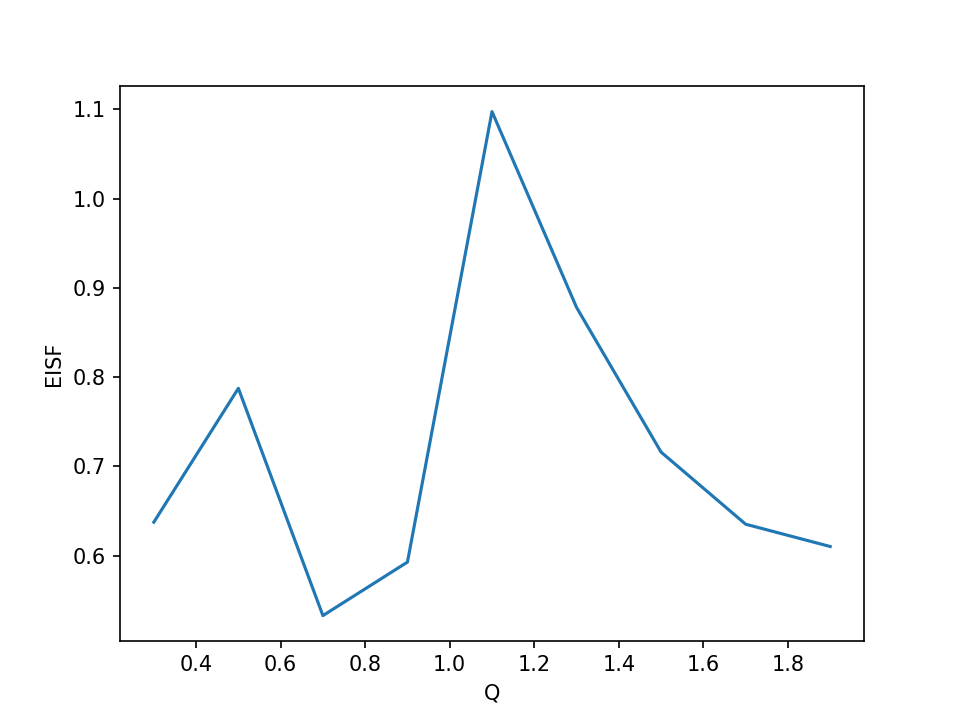

Text(0,0.5,u'EISF')

In [22]:
fig, ax = plt.subplots(1, 1)
ax.plot(q_values, eisf)
ax.set_xlabel('Q')
ax.set_ylabel('EISF')

The EISF signal is very small, as should be expected for a liquid water sample.